In [ ]:
!pip install cftime
!pip install netcdf4
!pip install scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 9.7 MB/s eta 0:00:00


In [ ]:
import cftime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
import scipy.integrate as inte
from scipy.stats import shapiro
import xarray as xr
import warnings
warnings.filterwarnings('ignore')


### Downloading CMIP6 data (not necessary for this tutorial)
CMIP6 search interface: https://esgf-node.llnl.gov/search/cmip6/

### Import data from Github

In [ ]:
# climate models
!wget https://github.com/KateDuffy/climate-ecology-tutorial/blob/main/tas_day_BCC-CSM2-MR_historical+ssp585_1850-2100.nc?raw=true
os.rename('tas_day_BCC-CSM2-MR_historical+ssp585_1850-2100.nc?raw=true','tas_day_BCC-CSM2-MR_historical+ssp585_1850-2100.nc')
!wget  https://github.com/KateDuffy/climate-ecology-tutorial/blob/main/tas_day_CESM2_historical+ssp585_1850-2100.nc?raw=true
os.rename('tas_day_CESM2_historical+ssp585_1850-2100.nc?raw=true','tas_day_CESM2_historical+ssp585_1850-2100.nc')
!wget  https://github.com/KateDuffy/climate-ecology-tutorial/blob/main/tas_day_EC-Earth3_historical+ssp585_1850-2100.nc?raw=true
os.rename('tas_day_EC-Earth3_historical+ssp585_1850-2100.nc?raw=true','tas_day_EC-Earth3_historical+ssp585_1850-2100.nc')
!wget  https://github.com/KateDuffy/climate-ecology-tutorial/blob/main/tas_day_INM-CM5-0_historical+ssp585_1850-2100.nc?raw=true
os.rename('tas_day_INM-CM5-0_historical+ssp585_1850-2100.nc?raw=true','tas_day_INM-CM5-0_historical+ssp585_1850-2100.nc')

# thermal performance data
!wget https://github.com/KateDuffy/climate-ecology-tutorial/blob/main/SD1.csv?raw=true
os.rename('SD1.csv?raw=true','SD1.csv')


--2023-11-11 06:50:21--  https://github.com/KateDuffy/climate-ecology-tutorial/blob/main/tas_day_BCC-CSM2-MR_historical+ssp585_1850-2100.nc?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/KateDuffy/climate-ecology-tutorial/raw/main/tas_day_BCC-CSM2-MR_historical+ssp585_1850-2100.nc [following]
--2023-11-11 06:50:22--  https://github.com/KateDuffy/climate-ecology-tutorial/raw/main/tas_day_BCC-CSM2-MR_historical+ssp585_1850-2100.nc
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/KateDuffy/climate-ecology-tutorial/main/tas_day_BCC-CSM2-MR_historical%2Bssp585_1850-2100.nc [following]
--2023-11-11 06:50:22--  https://raw.githubusercontent.com/KateDuffy/climate-ecology-tutorial/main/tas_day_BCC-CSM2-MR_historical%2Bssp585_1850-2100.nc
Resolvin

### Reading data using xarray

In [ ]:
model_1 = xr.open_dataset("tas_day_BCC-CSM2-MR_historical+ssp585_1850-2100.nc")
model_2 = xr.open_dataset("tas_day_CESM2_historical+ssp585_1850-2100.nc")
model_3 = xr.open_dataset("tas_day_EC-Earth3_historical+ssp585_1850-2100.nc")
model_4 = xr.open_dataset("tas_day_INM-CM5-0_historical+ssp585_1850-2100.nc")

# convert time dimension to plottable format
for model in [model_1, model_2, model_3, model_4]:
  try:
    datetimeindex = model.indexes['time'].to_datetimeindex()
    model["time"] = datetimeindex
  except:
    pass

model_1 = model_1.sel(time=slice("1850", "2099"))
model_2 = model_2.sel(time=slice("1850", "2099"))
model_3 = model_3.sel(time=slice("1850", "2099"))
model_4 = model_4.sel(time=slice("1850", "2099"))


### Plotting temperature data

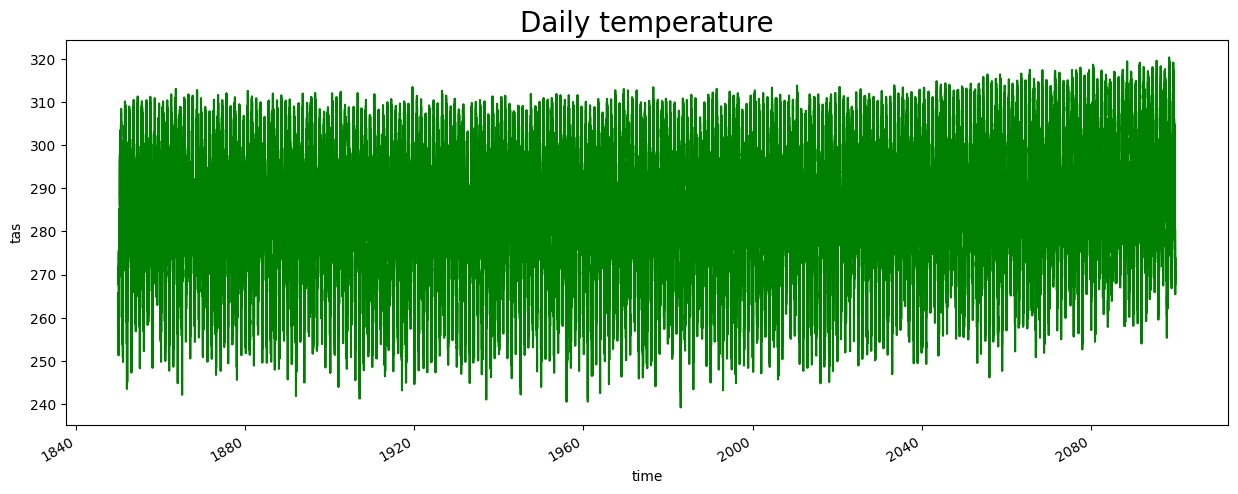

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
model_1.tas.plot(color="green")
plt.title("Daily temperature", size=20)
plt.show()


#### Computing and plotting temperature statisitics

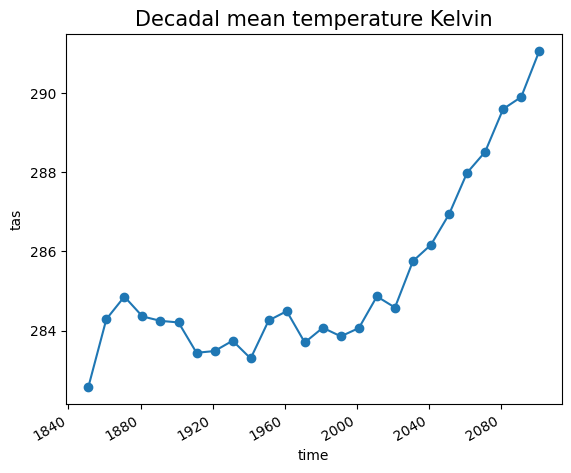

In [ ]:
model_1.resample(time='10Y').mean().tas.plot(marker="o")
plt.title("Decadal mean temperature Kelvin", size=15)
plt.show()


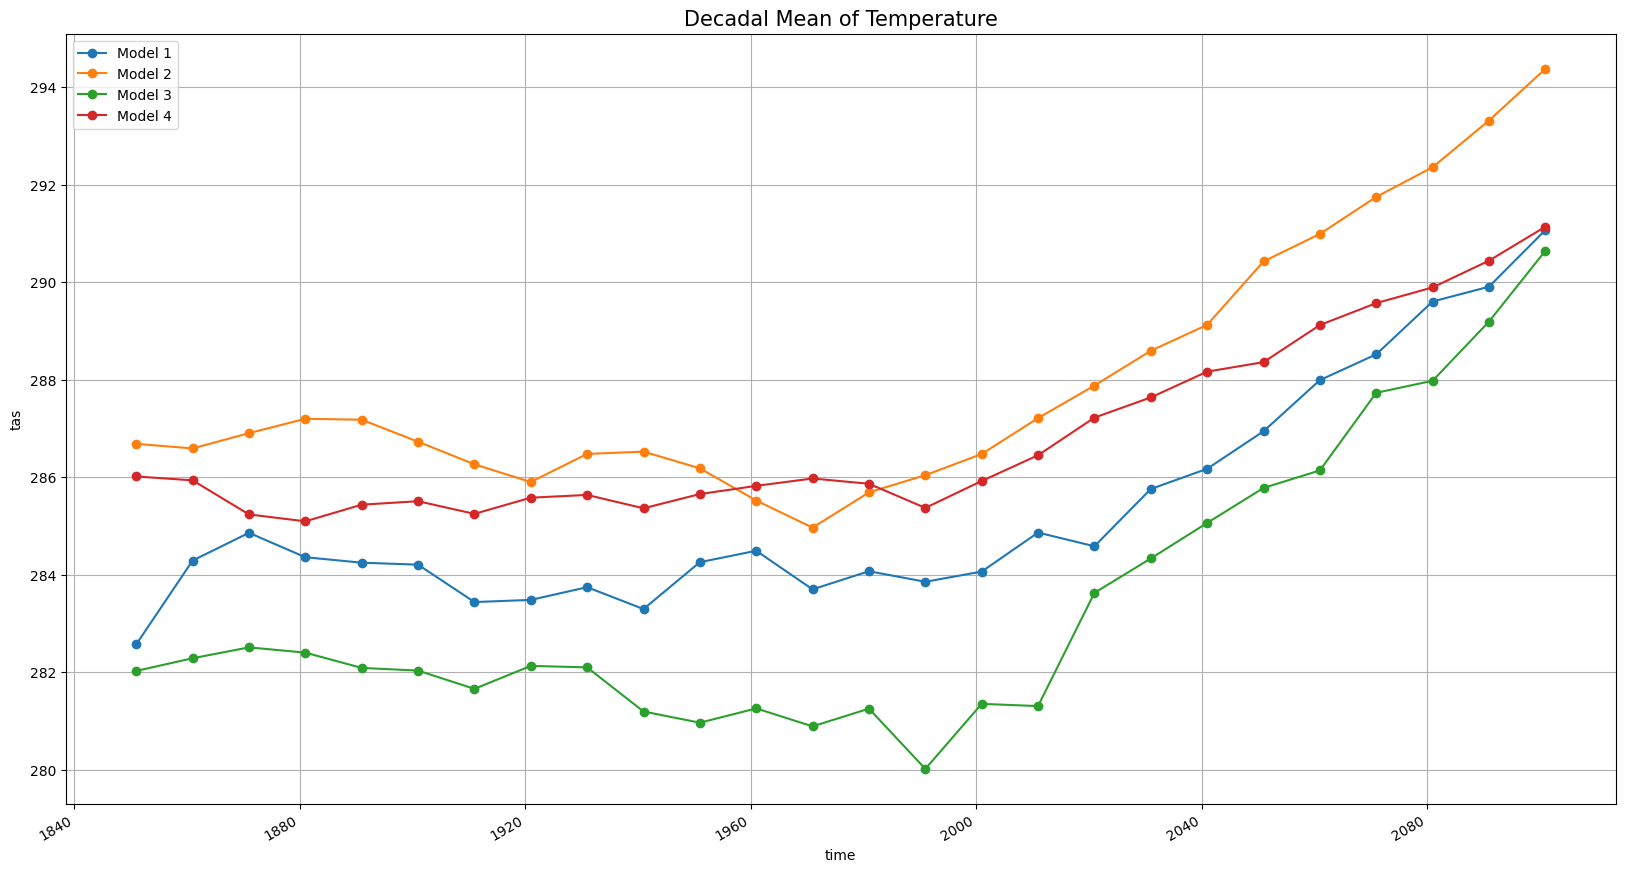

In [ ]:
plt.figure(figsize=[20,10])
for model in [model_1, model_2, model_3, model_4]:
  model.resample(time='10Y').mean().tas.plot(marker="o")

plt.title("Decadal Mean of Temperature", size=15)
plt.legend(['Model 1','Model 2','Model 3','Model 4'])
plt.grid ( which='major', axis='both')
plt.show()



### Detecting climate trends

In [ ]:
model = model_1

historical = model.sel(time=slice("1950", "1999"))
future = model.sel(time=slice("2050", "2099"))
print(historical)


<xarray.Dataset>
Dimensions:  (time: 18250)
Coordinates:
    lat      float64 ...
    lon      float64 ...
  * time     (time) datetime64[ns] 1950-01-01T12:00:00 ... 1999-12-31T12:00:00
Data variables:
    tas      (time) float64 ...


In [ ]:
x = historical.resample(time='1Y').mean().tas
y = future.resample(time='1Y').mean().tas

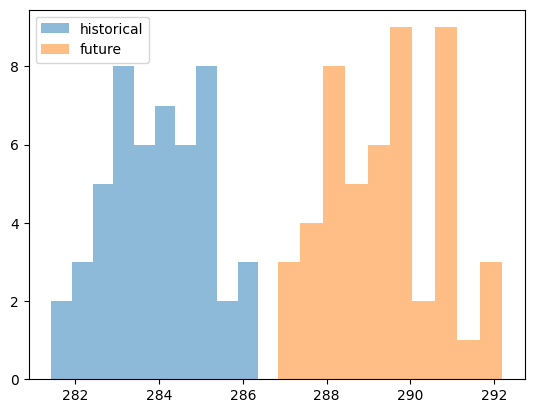

In [ ]:
plt.hist(x, alpha=0.5, label="historical")
plt.hist(y, alpha=0.5, label="future")
plt.legend()
plt.show()

In [ ]:
# test for normality
for data in [x,y]:
  stat, p = shapiro(data)

  alpha = 0.05
  if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
  else:
    print('Sample does not look Gaussian (reject H0)')


Sample looks Gaussian (fail to reject H0)
Sample looks Gaussian (fail to reject H0)


In [ ]:
# Two-sided t-test. Null hypothesis: the 2 independent samples have identical average (expected) values
t, p = stats.ttest_ind(x, y)
print("t(df=%s) = %s, p = %s" %((len(x) + len(y) - 2), np.round(t,2), np.round(p, 4)))

alpha = 0.05
if p > alpha:
 print('Samples have identical means (fail to reject H0)')
else:
 print('Samples do not have identical means (reject H0)')


t(df=98) = -21.19, p = 0.0
Samples do not have identical means (reject H0)


### Exploring thermal performance data




In [ ]:
TPC_data = pd.read_csv("SD1.csv")
print(len(TPC_data))
TPC_data

38


,Lat,Long,Order,Species,Location,Reference,NTEMP,TCLIM,SIGMA,CTmax,Topt,Ctmin,WT
0,-42.00,147.00,Hemiptera,Sitobion.fragariae,Tasmania,Turak_et_al_1998,4,7.9083,3.6731,27.7400,22.8200,5.9000,19.8317
1,-35.30,149.08,Hemiptera,Hyperomyzus.lactucae,Canberra_Australia,Shu-sheng_and_Hughes_1987,4,12.9000,5.5224,26.1000,23.0000,4.1000,13.2000
2,-33.00,152.00,Hemiptera,Sitobion.miscanthi,Northern_suburbs_of_Sydney,Turak_et_al_1998,5,17.8417,3.9700,29.0000,24.0000,7.2600,11.1583
3,-31.08,150.93,Hemiptera,Dactylopius.austrinus,5km_east_of_Tamworth_(31degree05'S_150degree56'E),Hosking_1984,8,16.0500,5.4705,35.9400,31.2000,15.4200,19.8900
4,-30.51,151.66,Hemiptera,Eriosoma.lanigerum,"Armidale,_New_South_Wales,_Australia",Asante_et_al_1991,6,13.5333,5.0825,34.0750,26.7250,3.5500,20.5417
5,-27.47,151.48,Coleoptera,Pterohelaeus.darlingensis,"Mt._Maria,_40_km_west_of_Toowoomba,_Qld",Allsopp_1981,4,18.7083,4.8920,34.5400,29.4200,14.2400,15.8317
6,-26.50,31.50,Coleoptera,Callosobruchus.rhodesianus,"Swaziland,_Africa",Giga_and_Smith_1983,4,20.8917,3.1248,35.8000,29.0333,17.8333,14.9083
7,-26.00,150.00,Coleoptera,Pterohalaeus.alternatus,"Boonarga,_7_km_east_of_Chinchilla_(australia?)",Allsopp_1981,4,20.0167,5.3731,30.5500,27.2000,19.2500,10.5333
8,-21.09,149.09,Hemiptera,Saccharicoccus.sacchari,Mackay_in_north-eastern_Australia,Rae_and_De'ath_1991,5,22.1500,3.6243,34.7800,30.6800,18.0200,12.6300
9,-3.00,40.00,Hymenoptera,Cotesia.sesamiae,Coast_Province_of_Kenya,Mbapila_and_Overholt_2001,4,26.1333,1.1555,36.6500,30.0500,6.5000,10.5167


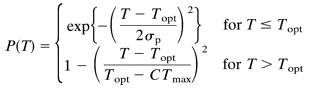

In [ ]:
def TPC_growth_rate_func(t, T_opt, sigma, T_max):
    if t <= T_opt:
        r = np.exp( - ( (t - T_opt) / (2 * sigma) ) ** 2)
    elif t > T_opt:
        r = 1 - ( (t - T_opt)/(T_opt - T_max) ) ** 2
    return r

TPC_growth_rate = np.vectorize(TPC_growth_rate_func)


In [ ]:
species = "Muscidifurax.raptorellus"
row = TPC_data[TPC_data["Species"] == species]
row


,Lat,Long,Order,Species,Location,Reference,NTEMP,TCLIM,SIGMA,CTmax,Topt,Ctmin,WT
30,40.82,-96.67,Hymenoptera,Muscidifurax.raptorellus,Lincoln_Nebraska,Lysyk_2001_(in_press),5,10.6667,11.1233,36.15,30.525,13.125,25.4833


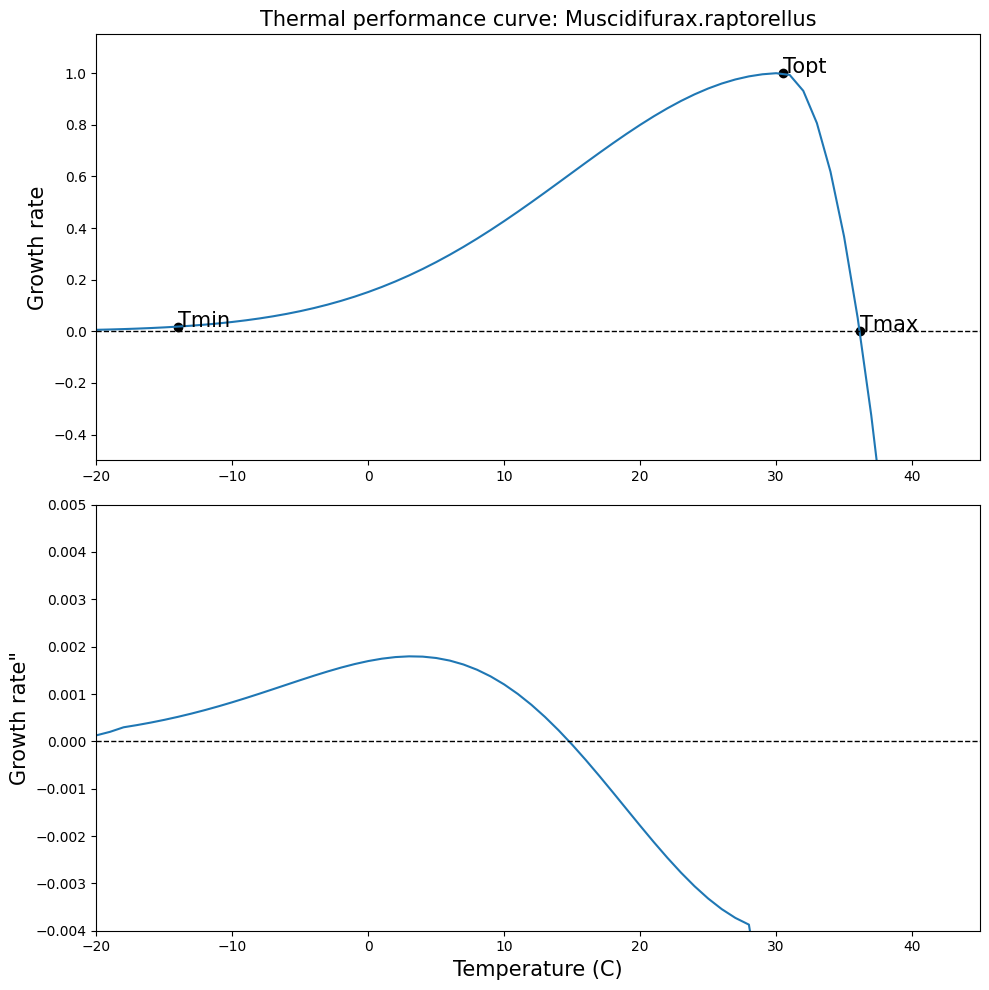

In [ ]:
# plot a thermal performance curve

x = np.arange(-20,40,1) #temperatures from -20 to 40 C
y = TPC_growth_rate(x, row.Topt, row.SIGMA, row.CTmax)


fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(x, y)
ax[0].plot((-20, 50), (0, 0), "--", c="black", lw=1)
ax[0].set_ylim(-0.5, 1.15)
ax[0].set_xlim(-20, 45)
ax[0].set_ylabel("Growth rate", size=15)
ax[0].set_title("Thermal performance curve: %s" %(species), size=15)

a = [row.Topt.item() - 4*row.SIGMA.item(), row.Topt, row.CTmax]
b = [TPC_growth_rate(v, row.Topt, row.SIGMA, row.CTmax) for v in a]
n = ["Tmin", "Topt", "Tmax"]
ax[0].scatter(a, b, c="black")
for i, txt in enumerate(n):
    ax[0].annotate(txt, (a[i], b[i]), size=15)


ax[1].plot(x, np.gradient(np.gradient(y)))
ax[1].plot((-20, 50), (0, 0), "--", c="black", lw=1)
ax[1].set_ylim(-0.004, 0.005)
ax[1].set_xlim(-20, 45)
ax[1].set_ylabel("Growth rate\"", size=15)
ax[1].set_xlabel("Temperature (C)", size=15)


plt.tight_layout()
plt.show()

In [ ]:
print(TPC_growth_rate(t=10, T_opt=row.Topt, sigma=row.SIGMA, T_max=row.CTmax))

[0.42689613]


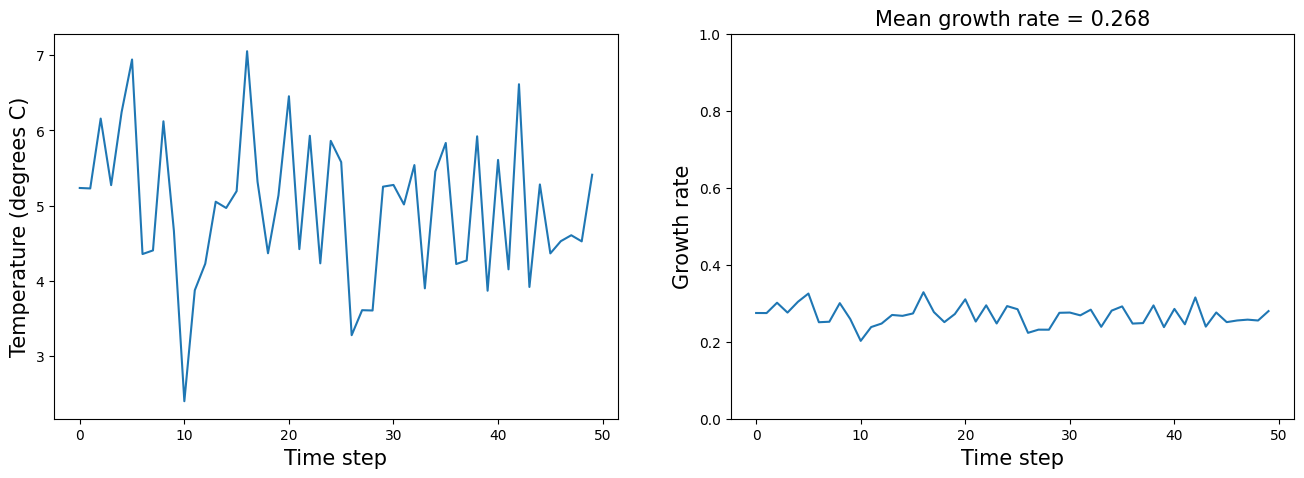

In [ ]:
# calculating the temperature-dependent growth rate using synthetic data

temperature = np.random.normal(loc=5, scale=1, size=50)
r = TPC_growth_rate(temperature, row.Topt, row.SIGMA, row.CTmax)

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(temperature)
ax[0].set_ylabel("Temperature (degrees C)", size=15)
ax[0].set_xlabel("Time step", size=15)

ax[1].plot(r)
ax[1].set_ylim(0,1)
ax[1].set_title("Mean growth rate = %s" % np.round(np.mean(r), 3), size=15)
ax[1].set_ylabel("Growth rate", size=15)
ax[1].set_xlabel("Time step", size=15)
plt.show()


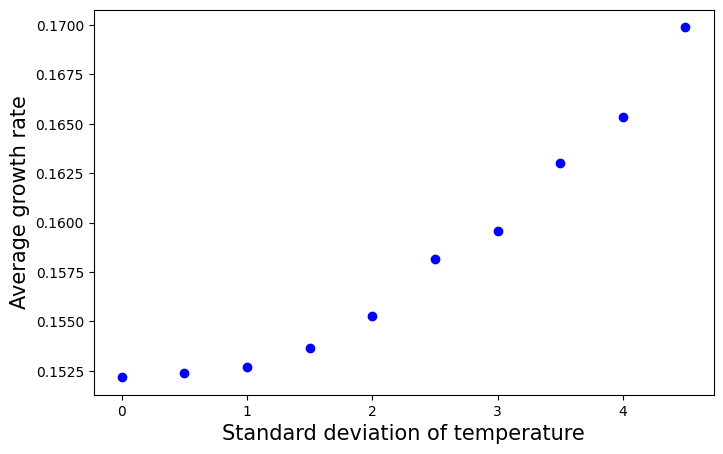

In [ ]:
# Demonstrating nonlinear averaging with synthetic data

fig, ax = plt.subplots(1,1, figsize=(8,5))

for sdev in np.arange(0, 5, 0.5):
  temperature = np.random.normal(loc=0, scale=sdev, size=5000)
  r = TPC_growth_rate(temperature, row.Topt, row.SIGMA, row.CTmax)
  plt.scatter(sdev, r.mean(), c="blue")

plt.ylabel("Average growth rate", size=15)
plt.xlabel("Standard deviation of temperature", size=15)
plt.show()

### Quantifying ecological fitness based on climate projections



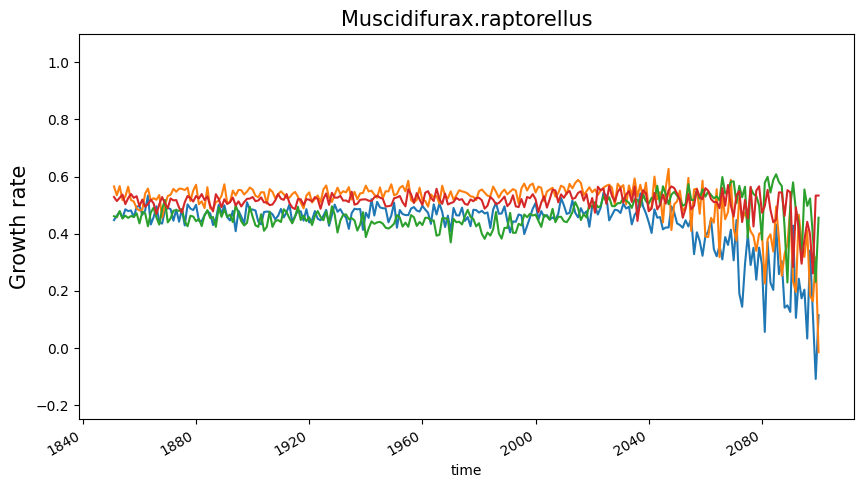

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

for model in [model_1, model_2, model_3, model_4]:
  r =  TPC_growth_rate(model.tas-273.15, row.Topt, row.SIGMA, row.CTmax)
  model["r"] = (("time"), r)

  model.resample(time='1Y').mean().r.plot()
  plt.ylim(-0.25,1.1)

plt.title(species, size=15)
plt.ylabel("Growth rate", size=15)
plt.show()
